In [4]:
!nvidia-smi

Fri May 17 15:31:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install imgaug

In [13]:
!pip install livelossplot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda
from livelossplot.keras import PlotLossesCallback

In [4]:
X = np.load('x.npy')
y = np.load('y.npy')

In [5]:
print(X.shape, y.shape)

(12588, 60, 80, 3) (12588,)


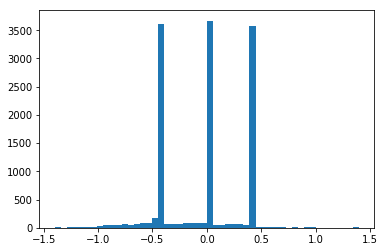

In [6]:
plt.hist(y, 50);

In [7]:
def augment(img, steering_angle):
  # Flip
  if random.random() > 0.5:
    img = img[:,::-1,:]
    steering_angle = -steering_angle
    
  # Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  
  # Shuffle
  sh = iaa.ChannelShuffle(0.5)
  img = sh.augment_image(img)
  
  # Fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  
  # Translate
  tx = random.randint(-20, 20)
  translator = iaa.Affine(translate_px={'x':tx}, mode='edge')
  img = translator.augment_image(img)
  steering_angle += tx*0.025
    
  return img, steering_angle

0.0


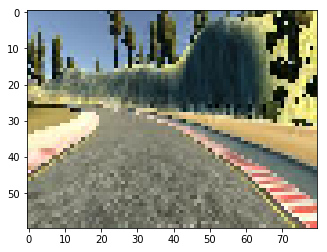

-0.225


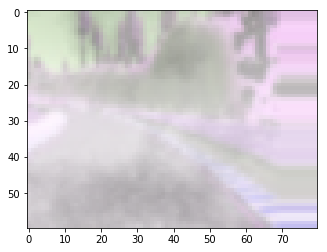

In [8]:
plt.imshow(X[0])
print(y[0])
plt.show();

img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, random_state=42)

In [10]:
X_gen = []
y_gen = []
for i in range(X_train.shape[0]):
  img, angle = augment(X[i], y[i])
  X_gen.append(img)
  y_gen.append(angle)
  
X_gen = np.array(X_gen)
y_gen = np.array(y_gen)
print(X_gen.shape, y_gen.shape)

(2517, 60, 80, 3) (2517,)


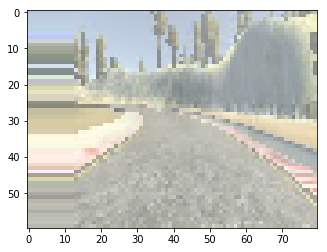

In [11]:
plt.imshow(X_gen[0])
plt.show();

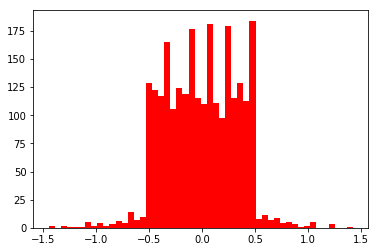

In [12]:
#plt.hist(y_train, 50, facecolor='green');
plt.hist(y_gen, 50, facecolor='red');

In [22]:
def mymodel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape, name='normalize'),
      Conv2D(64, (3, 3), activation='relu'),
      Conv2D(32, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(16, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(8, (3, 3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(512, activation='relu'),
      Dropout(rate=0.3),
      Dense(16, activation='relu'),
      Dense(1)
  ])
  
  return model

In [23]:
model = mymodel(X[0].shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 16, 8)         1160      
__________

In [24]:
batch_size = 512
epochs = 15

In [25]:
model.compile(optimizer='rmsprop',
              loss='mse')

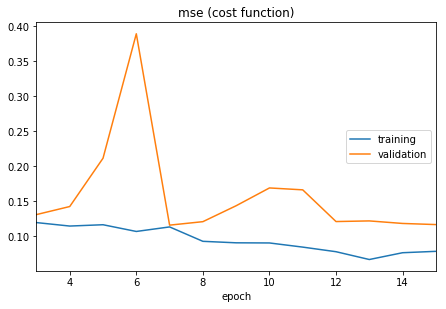

mse (cost function):
training   (min:    0.067, max:    0.120, cur:    0.079)
validation (min:    0.116, max:    0.389, cur:    0.117)


In [26]:
model.fit(X_gen, y_gen, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(X_val,y_val),
          callbacks=[PlotLossesCallback()])

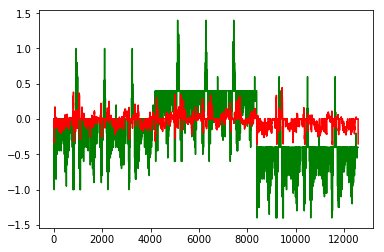

In [27]:
y_pred = model.predict(X)
plt.plot(y, 'g', y_pred, 'r')
plt.show();

In [28]:
model.save('mymodel.h5')